# WIP

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Import data

In [6]:
import os
import datetime as dt

main_path = os.getcwd()
start_date = pd.to_datetime('2018-03-01')
end_date = start_date + dt.timedelta(5*365)
period_pred = end_date + dt.timedelta(30)

df_P = pd.read_pickle(main_path+'\\data\\exchange_rates.pkl')
df_P = df_P.fillna(method='ffill').drop(df_P.index[0])
df_P = df_P.loc[(df_P.index > start_date) & (df_P.index < end_date)]

df_r = pd.read_pickle(main_path+'\\data\\log_return.pkl')
df_r = df_r.fillna(method='ffill').dropna()
df_r = df_r.loc[(df_r.index > start_date) & (df_r.index < end_date)]

In [48]:
df_P

,EUR/USD,CNY/USD,GBP/USD,CAD/USD,RUB/USD,JPY/USD,AUD/USD,CHF/USD,KRW/USD,HKD/USD,KWD/USD,BHD/USD,OMR/USD,KYD/USD,BSD/USD
Date,,,,,,,,,,,,,,,
2018-03-02,1.227084,0.157297,1.377543,0.779296,0.017610,0.009419,0.776470,1.062146,0.000924,0.127763,3.342805,2.669514,2.605592,1.224200,1.005834
2018-03-05,1.231542,0.157473,1.379501,0.775910,0.017558,0.009474,0.775470,1.067088,0.000927,0.127696,3.334445,2.670013,2.606203,1.224665,1.006208
2018-03-06,1.233654,0.157508,1.385233,0.770422,0.017726,0.009412,0.776699,1.064169,0.000929,0.127678,3.341130,2.669799,2.604099,1.223870,1.005773
2018-03-07,1.241665,0.158494,1.390009,0.772266,0.017594,0.009475,0.778634,1.065825,0.000941,0.127650,3.341687,2.669799,2.605592,1.223361,1.005460
2018-03-08,1.241465,0.158103,1.390627,0.774821,0.017609,0.009417,0.782712,1.059973,0.000938,0.127644,3.341241,2.669514,2.605524,1.223511,1.005540
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-21,1.068262,0.145898,1.203920,0.743329,0.013251,0.007444,0.690900,1.083212,0.000772,0.127650,3.269149,2.672204,2.606821,1.227387,1.006398
2023-02-22,1.065201,0.145507,1.210932,0.738831,0.013402,0.007409,0.686190,1.078167,0.000766,0.127473,3.267440,2.672204,2.606678,1.226725,1.005875
2023-02-23,1.060580,0.145111,1.204993,0.738258,0.013357,0.007411,0.681292,1.073837,0.000768,0.127467,3.265733,2.672246,2.606977,1.227997,1.006818


# Kalman filter fucntion

In [7]:
import numpy as np
from pykalman import KalmanFilter

def fitKCA(t,z,q,fwd=0):
    '''
    Args:
        t: iterable with time indices
        z: iterable with measurements
        q: scalar that multiplies the seed states covariance
        fwd: number of steps to forecast (default to 0)
    Returns:
        x[0]: smoothed state means of position velocity and acceleration
        x[1]: smoothed state covar of position velocity and acceleration
    '''
    #monthly timestep
    h = (t[-1] - t[0])/t.shape[0]
    
    A = np.array([[1, h, 0.5*h**2],
                 [0, 1, h],
                 [0, 0, 1]])
    Q = q*np.eye(A.shape[0])

    #set up Kalman filter
    kf = KalmanFilter(transition_matrices=A, transition_covariance=Q)

    #EM for parameter esimtates
    kf = kf.em(z)

    #smooth
    x_mean, x_cov = kf.smooth(z)

    #forecast
    for fwd_ in range(fwd):
        x_mean_, x_cov_ = kf.filter_update(filtered_state_mean=x_mean[-1],
                                         filtered_state_covariance=x_cov[-1])
        x_mean = np.append(x_mean, x_mean_.reshape(1,-1), axis=0)
        x_cov_ = np.expand_dims(x_cov_, axis=0)
        x_cov = np.append(x_cov, x_cov_, axis=0)

    #std series
    x_std = (x_cov[:,0,0]**0.5).reshape(-1,1)
    for i in range(1, x_cov.shape[1]):
        x_std_ = x_cov[:,i,i]**0.5
        x_std = np.append(x_std, x_std_.reshape(-1,1), axis=1)
        
    return x_mean, x_std, x_cov

## Demo with only 1 asset

In [8]:
# raw = pd.read_csv('C:/Users/janeg/cornell_projects/Opt_proj/DEXJPUS.csv')
# df = raw[raw['DATETIME'] >= '2000-05-01']
# df = df.set_index(pd.to_datetime(df['DATETIME'])).drop(columns=['DATETIME'])

t_date = df_P.index
t_day = np.array(range(len(t_date)))
t = np.array(range(len(t_date)))/20 #20 trading days
z = np.array(df_P.iloc[:,0])
z_r = np.array(df_r.iloc[:,0])
title = df_P.columns[0]


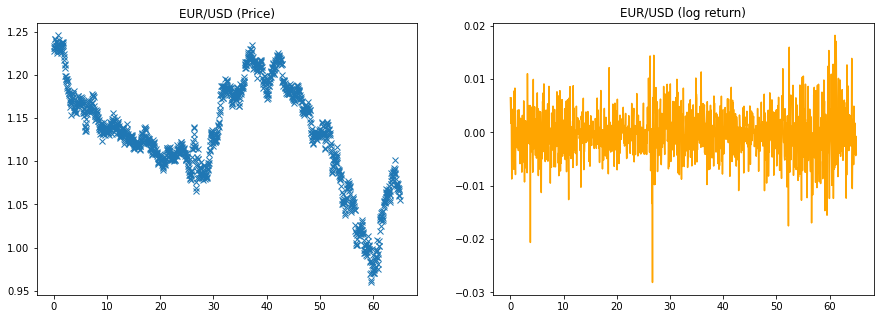

In [53]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,5))
ax1.plot(t,z,marker='x',linestyle='')
ax1.set_title(title+' (Price)')
ax2.plot(t,z_r,linestyle='-', color='orange')
ax2.set_title(title+' (log return)')
plt.show()

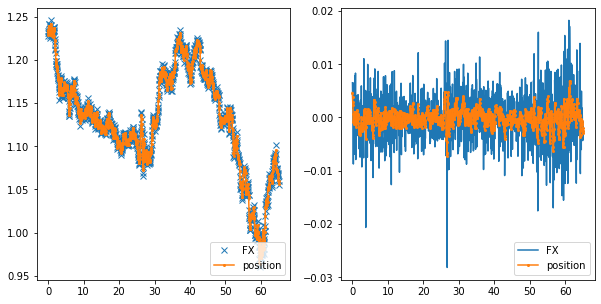

In [55]:
#smoothing result
x_point, x_bands = fitKCA(t, z, q=1e-5, fwd=0)[:2]
xr_point, xr_bands = fitKCA(t, z_r, q=1e-5, fwd=0)[:2]

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,5))
ax1.plot(t, z, marker='x', linestyle='',label='FX')
ax1.plot(t, x_point[:,0], marker='o', linestyle='-', markersize=2, label='position')
ax1.legend(loc="lower right")

ax2.plot(t, z_r, linestyle='-',label='FX')
ax2.plot(t, xr_point[:,0], marker='o', linestyle='-', markersize=2, label='position')
ax2.legend(loc="lower right")
plt.show()

In [56]:
mean_accel_P = x_point[:,2].mean()
mean_accel_r = xr_point[:,2].mean()
print(f"mean accelartion: P = {mean_accel_P:.6f}, r = {mean_accel_r:.6f}")

std_accel_P = x_point[:,2].std()
std_accel_r = xr_point[:,2].std()
print(f"std accelartion: P = {std_accel_P:.6f}, r = {std_accel_r:.6f}")


mean accelartion: P = -0.000554, r = 0.000057
std accelartion: P = 0.005165, r = 0.000683


## Apply Kalman Filter to all assets

In [7]:
r_km = np.zeros((df_r.shape))
for i in range(df_r.shape[1]):
    z_r = np.array(df_r.iloc[:,i])
    xr_point, xr_bands = fitKCA(t, z_r, q=1e-5, fwd=0)[:2]
    r_km[:,i] = xr_point[:,0]
df_export = pd.DataFrame(r_km)

In [9]:
# export r_km
df_export.to_pickle('r_km.pkl')

# Markowitz with monthly rebalancing

In [9]:
def adaptedStats(log_return, trade_date, horizon, rate_of_decay=0):
    """Projects filtered daily data to monthly holding data
    
    Args:
        log_return: filtered log_return from Kalman/ARIMA/GARCH/MCM
        trade_date: the day when rebalancing happens
        horizon: days of holding period (for monthly rebalacing, horizon=20)
        rate_of_decay: assigning weight to each return in history (the older, 
        the smaller weight). Default setting is 0

    Retuns:
        mu: arithmetic mean vector of historical returns 
        V: covariance matrix of arithmetic means
    """
    h = horizon
    c_r = log_return
    t_d = trade_date
    n_s = trade_date #use all the historical data available so far
    r_d = rate_of_decay

    s_d = np.array(range(t_d))
    s_c_r = c_r[s_d,:]  #sampled log return matrix

    #construct weights
    w = (1 - r_d)**np.array(range(n_s))
    w = w[::-1]/np.sum(w)

    #mean vector of compounded returns
    mean_c_r = s_c_r.T.dot(w)

    #covariance matrix of compounded returns
    cov_c_r = s_c_r.T.dot(np.diag(w)).dot(s_c_r) - mean_c_r.dot(mean_c_r.T)

    #adapted mean
    adapted_mean_c_r = h * mean_c_r

    #adapted covariance
    adapted_cov_c_r = h * cov_c_r

    #arithmetic mean for markowitz
    mu = np.exp(adapted_mean_c_r + 0.5*np.diag(adapted_cov_c_r)) - 1

    #covariance matrix of arithmetic mean
    V = mu.dot(mu.T)*(np.exp(adapted_cov_c_r) - 1)

    return mu, V


In [10]:
r_km = np.array(pd.read_pickle('r_km.pkl'))
horizon = 20 # rebalance monthly (every 20 trading days)
start = 250 #initial rebalancing strats at the 250th trading day
number_rebalances = int((t_day[-1]-start)/horizon) + 1
rebalance_dates = start + horizon * np.array(range(number_rebalances))
rate_of_decay = 0 #no decay

for i in range(len(rebalance_dates)):
    trade_date = rebalance_dates[i]
    mu, V = adaptedStats(r_km, trade_date, horizon, rate_of_decay)
    

In [11]:
#set up initial states of an equally-weighted portfolio
risk_free_rate = pd.read_pickle(main_path+'\\data\\risk_free_rate.pkl')
rf = pd.merge(risk_free_rate, df_r, left_index=True, right_index=True, how='right')['Close']
rf = rf.fillna(method='ffill') 
n = r_km.shape[1]
e = np.ones((n,1))

wealth = 10000
wealth0, benchmark_wealth = wealth,  wealth

benchmark_xx0, xx0 = 1/(n+1), 1/(n+1) # %money in bank
benchmark_xx, xx = e/(n+1), e/(n+1)  # %money in each of risky asset

mu0 = (1 + 0.01 * rf[trade_date - 1]) ** (horizon / 270) - 1

## Markowitz CVX

In [14]:
import cvxpy as cp

def benchmark(benchmark_xx0, benchmark_xx, trans_cost):
    n = len(benchmark_xx)
    w = cp.Variable()
    req = benchmark_xx0 + cp.sum(benchmark_xx) - trans_cost * cp.sum(cp.abs(w - benchmark_xx))
    prob = cp.Problem(cp.Maximize(w), [(n+1) * w <= req])
    prob.solve()

    return w.value


def markowitz(mu0, mu, V, sigma, xx0, xx, trans_cost, benchmark_x):

    return

In [16]:
trans_cost = 0.005
weight = benchmark(benchmark_xx0, benchmark_xx, trans_cost)
weight

array(0.0625)

### Tests

In [70]:
#test out adaptedStats for EUR/USD
horizon = 20 # rebalance monthly (every 20 trading days)
start = 250 #initial rebalancing strats at the 250th trading day
number_rebalances = int((t_day[-1]-start)/horizon) + 1
rebalance_dates = start + horizon * np.array(range(number_rebalances))
rate_of_decay = 0 #no decay


for i in range(len(rebalance_dates)):
    trade_date = rebalance_dates[i]

    #adaptedStats algo
    h = horizon
    c_r = r_km[:,0:2]
    t_d = trade_date
    s_f = 1 #daily sampling
    n_s = trade_date #use all the historical available so far
    r_d = rate_of_decay

    s_d = np.array(range(t_d))
    s_c_r = c_r[s_d,:]  #sampled log return matrix

    #construct weights
    w = (1 - r_d)**np.array(range(n_s))
    w = w[::-1]/np.sum(w)

    #mean vector of compounded returns
    mean_c_r = s_c_r.T.dot(w)

    #covariance matrix of compounded returns
    cov_c_r = s_c_r.T.dot(np.diag(w)).dot(s_c_r) - mean_c_r.dot(mean_c_r.T)

    #adapted mean
    adapted_mean_c_r = h * mean_c_r

    #adapted covariance
    adapted_cov_c_r = h * cov_c_r

    #arithmetic mean for markowitz
    mu = np.exp(adapted_mean_c_r + 0.5*np.diag(adapted_cov_c_r)) - 1

    #covariance matrix of arithmetic mean
    V = mu.dot(mu.T)*(np.exp(adapted_cov_c_r) - 1)


In [72]:
print(mu)
print(V)

[-0.00193894 -0.00105695]
[[2.63607758e-10 8.44491924e-11]
 [8.44491924e-11 1.33713444e-10]]


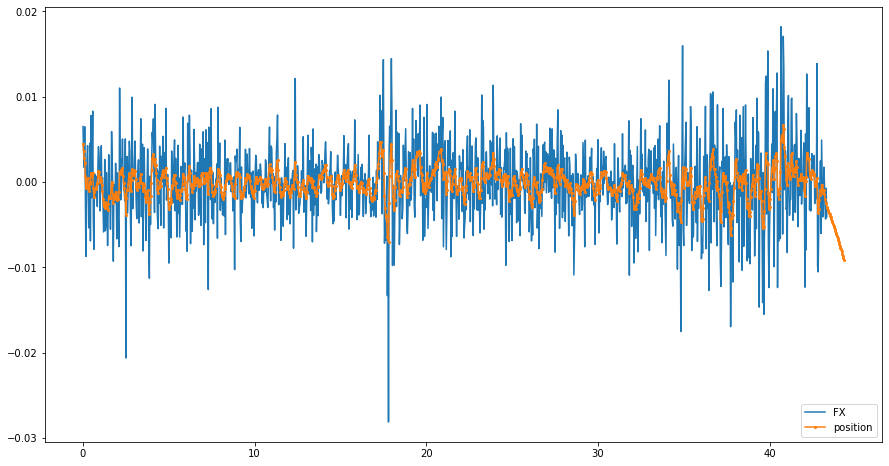

In [161]:
#predicting nexxt 30 steps
fwd_steps = 30
dt = t[1] - t[0]
t_fwd = t.copy()
for i in range(fwd_steps):
    t_fwd = np.append(t_fwd, t_fwd[-1]+dt)

x_point, x_bands = fitKCA(t_fwd, z, q=1e-5, fwd=fwd_steps)[:2]
xr_point, xr_bands = fitKCA(t_fwd, z_r, q=1e-5, fwd=fwd_steps)[:2]

# fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,5))
# ax1.plot(t, z, marker='x', linestyle='',label='FX')
# ax1.plot(t_fwd, x_point[:,0], marker='o', linestyle='-', markersize=2, label='position')
# ax1.legend(loc="lower right")

fig, ax2 = plt.subplots(figsize=(15,8))
ax2.plot(t, z_r, linestyle='-',label='FX')
ax2.plot(t_fwd, xr_point[:,0], marker='o', linestyle='-', markersize=2, label='position')
ax2.legend(loc="lower right")
plt.show()

### Paper code replication

In [130]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

def getPeriodic(periods, nobs, scale, seed=0):
    t = np.linspace(0, np.pi*periods/2., nobs)
    rnd = np.random.RandomState(seed)
    signal = np.sin(t)
    z = signal + scale * rnd.randn(nobs)
    return t, signal, z

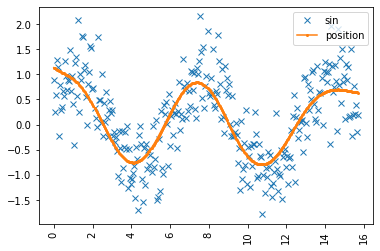

In [131]:
nobs, periods = 300, 10
t, signal, z = getPeriodic(periods, nobs, scale=0.5)
x_point, x_bands = fitKCA(t, z, q=1e-4)[:2]

plt.plot(t, z, marker='x', linestyle='',label='sin')
plt.plot(t, x_point[:,0], marker='o', linestyle='-', markersize=2, label='position')
plt.legend(loc="upper right")
plt.xticks(rotation=90)
plt.show()